# Model Evaluations

In [1]:
import datetime
import importlib
import json, pickle
import numpy as N
import numpy.random as NR
import matplotlib.pyplot as pyplot
import seaborn
import sklearn.metrics as SkM
import pandas as P
from pathlib import Path
from os import listdir
import tqdm
import re

seaborn.set_style('whitegrid')

## ARIMA Model

In [2]:
pathStocks = Path('datasets/Stocks')
pathARIMA = Path('models/arima')

df = P.DataFrame({}, columns = ['Symbol', 'MSE', 'MAPE', 'acc', 'f1'])

for file in listdir('models/arima'):
    if not re.match(r'.*\.csv', file):
        continue
    ticker = file.split(".")[0]
    real_df = P.read_csv(pathStocks / file).set_index('Date')
    predict_df = P.read_csv(pathARIMA / file).set_index('Date')
    real_df = real_df.loc[predict_df.index]
    
    mse = 0.0
    mape = 0.0
    sign_accuracy = 0.0

    num_days = predict_df.size
    
    b_pred = predict_df['Yhat'] >= 0
    b_real = real_df['Y'] >= 0
    f1 = SkM.f1_score(b_real, b_pred)
    acc = (b_real == b_pred).mean()
    
    df = df.append({
        'Symbol': ticker,
        'MSE': ((predict_df['Yhat'] - real_df['Y']) ** 2).mean(),
        'MAPE': (N.abs(predict_df['Xhat'] - real_df['X']) / N.abs(real_df['X'])).mean(),
        'acc': acc,
        'f1': f1,
    }, ignore_index=True)
    #df = df.append({'Symbol': ticker, 'MSE': mse, 'MAPE': mape, 'Sign Accuracy': sign_accuracy}, ignore_index = True)
df

,Symbol,MSE,MAPE,acc,f1
0,AAPL,1.140161,0.009741,0.604839,0.679739
1,BRK-B,0.646133,0.005935,0.588710,0.622222
2,BA,1.028650,0.010256,0.596774,0.662162
3,GS,0.676936,0.008587,0.588710,0.598425
4,GM,0.745423,0.008415,0.564516,0.635135
5,OXY,0.576735,0.008706,0.580645,0.535714
6,FB,1.564918,0.012219,0.500000,0.523077
7,^GSPC,0.630977,0.004626,0.580645,0.628571
8,QQQ,0.643995,0.006599,0.556452,0.658385
9,INTL,0.457793,0.010729,0.629032,0.610169


In [9]:
df.to_csv('analytics/stocks_arima.csv', index=False)

## DNN Models

In [3]:

startTrain = datetime.date(2017, 1, 1)
endTrain = datetime.date(2019, 1, 1)
startTest = endTrain
endTest = datetime.date(2019, 7, 1)

ticker = "^DJI"
stockDf = P.read_csv(pathStocks / f'{ticker}.csv').set_index('Date')
stockDf.index = stockDf.index.map(datetime.datetime.fromisoformat).map(lambda x:x.date())
stockDf_test = stockDf[stockDf.index.map(lambda x:startTest <= x and x < endTest)]

In [23]:
def read_dnn_raw(name):
    df = P.read_csv(f'analytics/{name}_{ticker}_raw.csv').rename({'date': 'Date'}, axis=1)
    df['Date'] = df['Date'].map(datetime.datetime.fromisoformat).map(lambda x:x.date())
    return df

def assess_dnn_performance(df):
    df_pred = df.groupby(['Date']).mean()
    df_pred['Xhat'] = df_pred['Yhat'] * stockDf_test['sigma_hat'] + stockDf_test['X']
    df_pred['Xhat'] = df_pred['Xhat'].shift(1)
    
    df_pred_var = df.groupby(['Date']).std()
    
    y = stockDf_test['Y']
    yHat = df_pred['Yhat']
    x = stockDf_test['X'].iloc[1:]
    xHat = df_pred['Xhat'].iloc[1:]
    
    b_pred = yHat >= 0
    b_real = y >= 0
    f1 = SkM.f1_score(b_real, b_pred)
    acc = (b_real == b_pred).mean()
    
    return {
        'MSE': N.mean((y - yHat) ** 2),
        'MAPE': N.mean(N.abs(x - xHat) / N.abs(x)),
        'acc': acc,
        'f1': f1,
    }

df = read_dnn_raw('cnn')
perf = assess_dnn_performance(df)
perf

{'MSE': 0.7785334846965553,
 'MAPE': 0.005231977392206981,
 'acc': 0.4274193548387097,
 'f1': 0.42276422764227634}

In [27]:

df = read_dnn_raw('cnnatt')
perf = assess_dnn_performance(df)
perf

{'MSE': 0.6948183389006156,
 'MAPE': 0.004745289877713803,
 'acc': 0.5,
 'f1': 0.6555555555555556}

In [28]:
df_arima = P.read_csv(pathARIMA / '^DJI.csv').set_index('Date')
df_arima.index = df_arima.index.map(datetime.datetime.fromisoformat).map(lambda x:x.date())
df_arima

,Yhat,Xhat
Date,,
2019-01-02,-0.007772,22528.315379
2019-01-03,-0.292445,22511.023621
2019-01-04,0.401543,22120.690018
2019-01-07,0.086255,22615.057498
2019-01-08,0.151053,22838.143968
...,...,...
2019-06-24,0.050884,25743.577051
2019-06-25,-0.188640,25772.496937
2019-06-26,-0.000278,25620.734028


In [38]:
df.groupby('Date').mean().reset_index()['Yhat']

0     -0.186443
1     -0.070178
2     -0.025034
3     -0.052049
4     -0.129419
         ...   
119    0.113081
120    0.091237
121    0.080795
122    0.088468
123    0.011438
Name: Yhat, Length: 124, dtype: float64

In [47]:
df_plot = P.DataFrame({
    'Date': list(stockDf_test.index),
}).set_index('Date')
df_plot['truth'] = stockDf_test['Y']
df_plot['ARIMA'] = df_arima['Yhat']
df_plot['CNN-Attention'] = df.groupby('Date').mean()['Yhat']
df_plot

,truth,ARIMA,CNN-Attention
Date,,,
2019-01-02,-0.432813,-0.007772,-0.186443
2019-01-03,0.501854,-0.292445,-0.070178
2019-01-04,0.945615,0.401543,-0.025034
2019-01-07,0.541286,0.086255,-0.052049
2019-01-08,0.227498,0.151053,-0.129419
...,...,...,...
2019-06-24,-0.221420,0.050884,0.113081
2019-06-25,-0.284319,-0.188640,0.091237
2019-06-26,-0.297328,-0.000278,0.080795


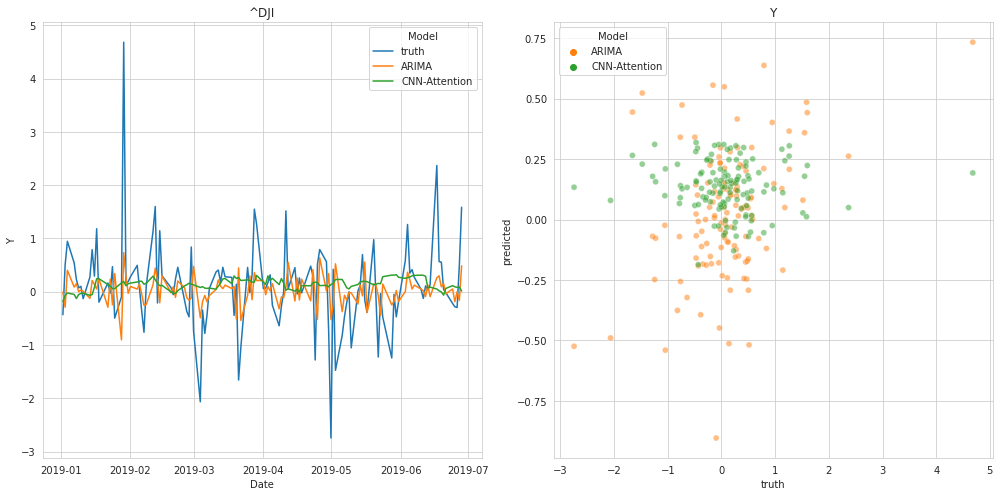

In [69]:
fig, axs = pyplot.subplots(1,2, figsize=(14,7))
seaborn.lineplot(x='Date', y='Y', hue='Model', ax=axs[0],
                 data=df_plot.reset_index().melt(id_vars='Date', var_name='Model', value_name='Y'))
axs[0].set_title(ticker)
import itertools
palette = seaborn.color_palette(n_colors=3)
palette = itertools.cycle(palette)
next(palette)
#next(palette)
seaborn.scatterplot(x='truth', y='predicted', hue='Model', palette=palette, alpha=0.5, ax=axs[1],
                 data=df_plot.reset_index().melt(id_vars=['truth', 'Date'], var_name='Model', value_name='predicted'))
axs[1].set_title('Y')
fig.tight_layout()
fig.savefig(f'analytics/trend_compare_{ticker}.png', dpi=300)